In [12]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np
from statesim.system.cartpole import CartPole
from statesim.generate.input import random_static_input
from statesim.system.inverted_pendulum import InvertedPendulum
from statesim.system.coupled_msd import CoupledMsd
from statesim.model.statespace import Lure
from statesim.simulator import DiscreteSimulator
from statesim.analysis.plot_simulation_results import (
    plot_states,
    plot_outputs,
    plot_inputs,
)
from statesim.analysis.system_analysis import SystemAnalysisContinuous

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
system = CartPole(mu_p=0.01)
x_bar = np.array([[0], [0], [np.pi], [0]])
A_symb, B_symb = system.get_linearization()
A_c, B_c = system.evaluate_linearization(
    A_sym=A_symb, B_sym=B_symb, x_bar=x_bar, u_bar=np.array([[0]])
)
C_c = np.array([[0, 0, 1, 0]])
D_c = np.array([[0]])
# discretize
eta = 0.001
A_lin = A_c * eta + np.eye(system.nx)
B_lin = B_c * eta
C_lin = np.array([[0, 0, 1, 0]])

ana = SystemAnalysisContinuous((A_c, B_c, C_c, D_c))
ana.analysis()

gamma = 5

Is system stable?: False
H inf norm: inf
Peak gain: 1.1446022383591625
Eigenvalues: [ 0.          0.         -0.16097561 -0.16097561]


In [5]:
# l2 stability
nx = system.nx  # state of rnn and lti
ny = nx  # output of lti
nu = nx  # output of rnn
nwp = system.nu  # external input (performance)
nzp = system.ny  # external output (performance)
nzu = 10  # uncertainty output
nwu = nzu  # uncertainty input

In [6]:
X = cp.Variable(shape=(nx, nx))
Y = cp.Variable(shape=(nx, nx))
lam = cp.Variable(shape=(nzu, 1), pos=True, name='lam')
Lambda = cp.diag(lam)

K = cp.Variable(shape=(nx, nx))
L1 = cp.Variable(shape=(nx, nwp))
L2 = cp.Variable(shape=(nx, ny))
L3 = cp.Variable(shape=(nx, nwu))

M1 = cp.Variable(shape=(nu, nx))
N11 = cp.Variable(shape=(nu, nwp))
N12 = cp.Variable(shape=(nu, ny))
N13 = cp.Variable(shape=(nu, nwu))

M2_tilde = cp.Variable(shape=(nzu, nx))
N21_tilde = cp.Variable(shape=(nzu, nwp))
N22_tilde = cp.Variable(shape=(nzu, ny))
N23_tilde = cp.Variable(shape=(nzu, nwu))

P_21_1 = cp.bmat(
    [
        [A_lin @ Y, A_lin, B_lin, np.zeros(shape=(nx, nwu))],
        [
            np.zeros(shape=(nu, nx)),
            X @ A_lin,
            X @ B_lin,
            np.zeros(shape=(nx, nwu)),
        ],
        [
            C_lin @ Y,
            C_lin,
            np.zeros(shape=(nzp, nwp)),
            np.zeros(shape=(nzp, nwu)),
        ],
        [
            np.zeros(shape=(nzu, nx)),
            np.zeros(shape=(nzu, nx)),
            np.zeros(shape=(nzu, nwp)),
            np.zeros(shape=(nzu, nwu)),
        ],
    ]
)
P_21_2 = cp.bmat(
    [
        [np.zeros(shape=(nx, nx)), A_lin, np.zeros(shape=(nx, nzu))],
        [np.eye(nx), np.zeros(shape=(nx, nu)), np.zeros(shape=(nx, nzu))],
        [np.zeros(shape=(nzp, nx)), C_lin, np.zeros(shape=(nzp, nzu))],
        [np.zeros(shape=(nzu, nx)), np.zeros(shape=(nzu, nu)), np.eye(nzu)],
    ]
)
P_21_3 = cp.bmat(
    [
        [K, L1, L2, L3],
        [M1, N11, N12, N13],
        [M2_tilde, N21_tilde, N22_tilde, N23_tilde],
    ]
)
P_21_4 = cp.bmat(
    [
        [
            np.zeros(shape=(nx, nx)),
            np.eye(nx),
            np.zeros(shape=(nx, nwp)),
            np.zeros(shape=(nx, nwu)),
        ],
        [
            np.zeros(shape=(nwp, nx)),
            np.zeros(shape=(nwp, nx)),
            np.eye(nwp),
            np.zeros(shape=(nwp, nwu)),
        ],
        [
            np.eye(ny),
            np.zeros(shape=(ny, nx)),
            np.zeros(shape=(ny, nwp)),
            np.zeros(shape=(ny, nwu)),
        ],
        [
            np.zeros(shape=(nwu, nx)),
            np.zeros(shape=(nwu, nx)),
            np.zeros(shape=(nwu, nwp)),
            np.eye(nwu),
        ],
    ]
)
print(
    f'sizes: P_21_1 {P_21_1.shape}, P_21_2 {P_21_2.shape}, P_21_3 {P_21_3.shape}, P_21_4 {P_21_4.shape}'
)

P_21 = P_21_1 + P_21_2 @ P_21_3 @ P_21_4
P_11 = -cp.bmat(
    [
        [Y, np.eye(nx), np.zeros(shape=(nx, nwp)), np.zeros(shape=(nx, nwu))],
        [np.eye(nx), X, np.zeros(shape=(nx, nwp)), np.zeros(shape=(nx, nwu))],
        [
            np.zeros(shape=(nwp, nx)),
            np.zeros(shape=(nwp, nx)),
            gamma * np.eye(nwp),
            np.zeros(shape=(nwp, nwu)),
        ],
        [
            np.zeros(shape=(nzu, nx)),
            np.zeros(shape=(nzu, nx)),
            np.zeros(shape=(nzu, nwp)),
            Lambda,
        ],
    ]
)
P_22 = -cp.bmat(
    [
        [Y, np.eye(nx), np.zeros(shape=(nx, nzp)), np.zeros(shape=(nx, nwu))],
        [np.eye(nx), X, np.zeros(shape=(nx, nzp)), np.zeros(shape=(nx, nwu))],
        [
            np.zeros(shape=(nzp, nx)),
            np.zeros(shape=(nzp, nx)),
            np.eye(nzp),
            np.zeros(shape=(nzp, nwu)),
        ],
        [
            np.zeros(shape=(nzu, nx)),
            np.zeros(shape=(nzu, nx)),
            np.zeros(shape=(nzu, nzp)),
            Lambda,
        ],
    ]
)
P = cp.bmat([[P_11, P_21.T], [P_21, P_22]])

sizes: P_21_1 (19, 19), P_21_2 (19, 18), P_21_3 (18, 19), P_21_4 (19, 19)


In [7]:
# back transformation to original parameter set
# 1. solve synthesis inequalities to determine X,Y and K,L,M,N, Lambda
t = cp.Variable(shape=1, name='t')
nP = P.shape[0]
objective = cp.Minimize(expr=None)
problem = cp.Problem(
    objective=objective, constraints=[P << -1e-4 * np.eye(nP)]
)
problem.solve(solver=cp.MOSEK)

print(f'problem status: {problem.status}')
print(
    f'Max real eigenvalue of P: {np.max(np.real(np.linalg.eig(P.value)[0]))}'
)

Lambda_inv = np.linalg.inv(Lambda.value)
M2 = Lambda_inv @ M2_tilde.value
N21 = Lambda_inv @ N21_tilde.value
N22 = Lambda_inv @ N22_tilde.value
N23 = Lambda_inv @ N23_tilde.value

# 2. Determine non-singular U,V with V U^T = I - Y X
U = X.value
V = np.linalg.inv(X.value) - Y.value
# print(V@U.T + Y.value @ X.value)
assert np.linalg.norm(V @ U.T + Y.value @ X.value - np.eye(nx)) < 1e-4

# 3. transform to original parameters
left_mult = np.concatenate(
    [
        np.concatenate([U, X.value @ A_lin, np.zeros((nx, nwu))], axis=1),
        np.concatenate(
            [np.zeros((nu, nx)), np.eye(nu), np.zeros((nu, nwu))], axis=1
        ),
        np.concatenate(
            [np.zeros((nzu, nx)), np.zeros((nzu, nu)), np.eye(nwu)], axis=1
        ),
    ],
    axis=0,
)
right_mult = np.concatenate(
    [
        np.concatenate(
            [
                np.zeros((nx, nx)),
                np.zeros(shape=(nx, nwp)),
                V.T,
                np.zeros((nx, nwu)),
            ],
            axis=1,
        ),
        np.concatenate(
            [
                np.zeros(shape=(nwp, nx)),
                np.eye(nwp),
                np.zeros(shape=(nwp, nx)),
                np.zeros(shape=(nwp, nwu)),
            ],
            axis=1,
        ),
        np.concatenate(
            [
                np.eye(nx),
                np.zeros(shape=(nx, nwp)),
                Y.value,
                np.zeros((nu, nwu)),
            ],
            axis=1,
        ),
        np.concatenate(
            [
                np.zeros((nzu, nx)),
                np.zeros(shape=(nzu, nwp)),
                np.zeros((nzu, ny)),
                np.eye(nwu),
            ],
            axis=1,
        ),
    ],
    axis=0,
)
middle = np.concatenate(
    [
        np.concatenate([K.value, L1.value, L2.value, L3.value], axis=1),
        np.concatenate(
            [
                M1.value,
                N11.value,
                N12.value - X.value @ A_lin @ Y.value,
                N13.value,
            ],
            axis=1,
        ),
        np.concatenate([M2, N21, N22, N23], axis=1),
    ],
    axis=0,
)
orig_par = np.round(
    np.linalg.inv(left_mult) @ middle @ np.linalg.inv(right_mult), 2
)
print(f'Original parameter shape: {orig_par.shape}')
# print(np.round(orig_par, 2))
A_tilde = orig_par[:nx, :nx]
B1_tilde = orig_par[:nx, nx : nx + nwp]
B2_tilde = orig_par[:nx, nx + nwp : nx + nwp + ny]
B3_tilde = orig_par[:nx, nx + nwp + ny : nx + nwp + ny + nwu]

C1_tilde = orig_par[nx : nx + nu, :nx]
D11_tilde = orig_par[nx : nx + nu, nx : nx + nwp]
D12_tilde = orig_par[nx : nx + nu, nx + nwp : nx + nwp + ny]
D13_tilde = orig_par[nx : nx + nu, nx + nwp + ny : nx + nwp + ny + nwu]

C2 = orig_par[nx : nx + nu, :nx]
D21 = orig_par[nx : nx + nu, nx : nx + nwp]
D22 = orig_par[nx : nx + nu, nx + nwp : nx + nwp + ny]
D23 = orig_par[nx : nx + nu, nx + nwp + ny : nx + nwp + ny + nwu]

D22 = orig_par[nx + nu : nx + nu + nzu, nx : nx + ny]
assert np.linalg.norm(orig_par[-nwu:-1, -nwu:-1]) < 1e-8
print(
    f'A_tilde: {A_tilde} \n B1_tilde: {B1_tilde} \n B2_tilde: {B2_tilde} \n B3_tilde: {B3_tilde} \n C1_tilde: {C1_tilde} \n D11_tilde: {D11_tilde} \n D12_tilde: {D12_tilde} \n D13_tilde: {D13_tilde} \n C2: {C2} \n D22: {D22} \n D23: {D23}'
)
# print(orig_par)

problem status: optimal
Max real eigenvalue of P: -0.9999999999999876
Original parameter shape: (18, 19)
A_tilde: [[-5.2  -0.01  0.    0.  ]
 [-0.   -5.2   0.01  0.  ]
 [-0.   -0.   -5.2  -0.01]
 [ 0.    0.    0.15 -5.2 ]] 
 B1_tilde: [[-0.]
 [-0.]
 [ 0.]
 [-0.]] 
 B2_tilde: [[-0. -0.  0. -0.]
 [ 0. -0.  0. -0.]
 [ 0. -0. -0. -0.]
 [-0. -0.  0. -0.]] 
 B3_tilde: [[ 0.  0.  0. -0.  0.  0.  0. -0.  0. -0.]
 [ 0. -0. -0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0. -0.  0. -0. -0. -0.]
 [-0. -0. -0.  0.  0. -0.  0.  0.  0.  0.]] 
 C1_tilde: [[ 4.13  0.   -0.    0.  ]
 [ 0.    4.13 -0.   -0.  ]
 [ 0.   -0.    4.13  0.  ]
 [-0.   -0.   -0.07  4.13]] 
 D11_tilde: [[ 0.]
 [-0.]
 [ 0.]
 [-0.]] 
 D12_tilde: [[-1. -0. -0.  0.]
 [-0. -1. -0.  0.]
 [-0.  0. -1.  0.]
 [ 0. -0. -0. -1.]] 
 D13_tilde: [[-0. -0. -0.  0. -0. -0. -0.  0. -0.  0.]
 [-0.  0.  0. -0. -0.  0.  0. -0.  0.  0.]
 [ 0.  0. -0.  0. -0.  0. -0.  0. -0. -0.]
 [ 0.  0.  0. -0. -0.  0. -0. -0. -0.  0.]] 
 C2: [[ 4.13  0.   -0.

cal: [[ 0.   0.   0.   0.   4.1  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   4.1 -0.  -0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   4.1  0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.1  4.1  0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -5.2 -0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -5.2  0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -5.2 -0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.2 -5.2  0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   4.1  0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.

/Users/jack/Documents/python_venv/statesim/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  func(*args, **kwargs)
/Users/jack/Documents/python_venv/statesim/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


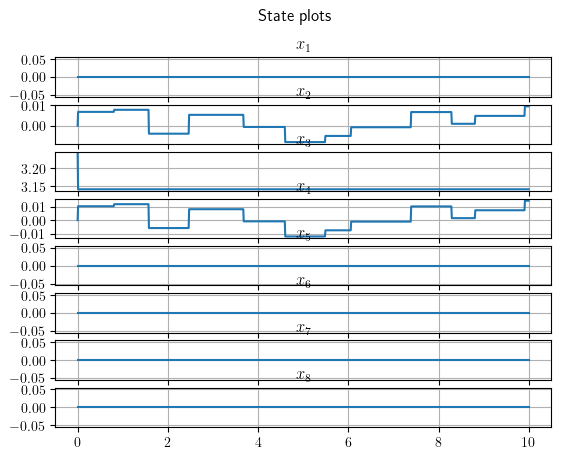

In [17]:
beta = 1
alpha = 0
Delta = lambda z: np.tanh(z)
Delta_tilde = lambda z: (2 / beta - alpha) * (
    Delta(z) - ((alpha + beta) / 2) * z
)

cal_1 = np.concatenate(
    [
        np.concatenate(
            [
                A_lin,
                np.zeros(shape=(nx, nx)),
                B_lin,
                np.zeros(shape=(nx, nwu)),
            ],
            axis=1,
        ),
        np.zeros(shape=(nx, nx + nx + nwp + nwu)),
        np.concatenate(
            [
                C_lin,
                np.zeros(shape=(nzp, nx)),
                np.zeros(shape=(nzp, nwp)),
                np.zeros(shape=(nzp, nwu)),
            ],
            axis=1,
        ),
        np.zeros(shape=(nzu, nx + nx + nwp + nwu)),
    ],
    axis=0,
)
cal_2 = np.concatenate(
    [
        np.concatenate(
            [np.zeros(shape=(nx, nx)), A_lin, np.zeros(shape=(nx, nzu))],
            axis=1,
        ),
        np.concatenate(
            [np.eye(nx), np.zeros(shape=(nx, nu)), np.zeros(shape=(nx, nzu))],
            axis=1,
        ),
        np.concatenate(
            [np.zeros(shape=(nzp, nx)), C_lin, np.zeros(shape=(nzp, nzu))],
            axis=1,
        ),
        np.concatenate(
            [
                np.zeros(shape=(nzu, nx)),
                np.zeros(shape=(nzu, nu)),
                np.eye(nzu),
            ],
            axis=1,
        ),
    ],
    axis=0,
)
cal_4 = np.concatenate(
    [
        np.concatenate(
            [
                np.zeros(shape=(nx, nx)),
                np.eye(nx),
                np.zeros(shape=(nx, nwp)),
                np.zeros(shape=(nx, nwu)),
            ],
            axis=1,
        ),
        np.concatenate(
            [
                np.zeros(shape=(nwp, nx)),
                np.zeros(shape=(nwp, nx)),
                np.eye(nwp),
                np.zeros(shape=(nwp, nwu)),
            ],
            axis=1,
        ),
        np.concatenate(
            [
                np.eye(ny),
                np.zeros(shape=(ny, nx)),
                np.zeros(shape=(ny, nwp)),
                np.zeros(shape=(ny, nwu)),
            ],
            axis=1,
        ),
        np.concatenate(
            [
                np.zeros(shape=(nwu, nx)),
                np.zeros(shape=(nwu, nx)),
                np.zeros(shape=(nwu, nwp)),
                np.eye(nwu),
            ],
            axis=1,
        ),
    ],
    axis=0,
)
cal = cal_1 + cal_2 @ orig_par @ cal_4
A_cal = cal[: nx + nx, : nx + nx]
B1_cal = cal[: nx + nx, nx + nx : nx + nx + nwp]
B2_cal = cal[: nx + nx, nx + nx + nwp : nx + nx + nwp + nwu]

C1_cal = cal[nx + nx : nx + nx + nzp, : nx + nx]
D11_cal = cal[nx + nx : nx + nx + nzp, nx + nx : nx + nx + nwp]
D12_cal = cal[nx + nx : nx + nx + nzp, nx + nx + nwp : nx + nx + nwp + nwu]

C2_cal = cal[nx + nx + nzp : nx + nx + nzp + nzu, : nx + nx]
D21_cal = cal[nx + nx + nzp : nx + nx + nzp + nzu, nx + nx : nx + nx + nwp]
D22_cal = cal[
    nx + nx + nzp : nx + nx + nzp + nzu, nx + nx + nwp : nx + nx + nwp + nwu
]
print(f'cal: {np.round(cal,1)}')
print(
    f'shapes: A_cal {A_cal.shape}, B1_cal {B1_cal.shape}, B2_cal {B2_cal.shape}, C1_cal {C1_cal.shape}, D11_cal {D11_cal.shape}, D12_cal {D12_cal.shape}, C2_cal {C2_cal.shape}, D21_cal {D21_cal.shape}'
)

print(
    f'values:\n A_cal {A_cal},\n B1_cal {B1_cal},\n B2_cal {B2_cal},\n C1_cal {C1_cal},\n D11_cal {D11_cal}, D12_cal {D12_cal},\n C2_cal {C2_cal},\n D21_cal {D21_cal}'
)

model = Lure(
    A=A_cal,
    B1=B1_cal,
    B2=B2_cal,
    C1=C1_cal,
    D11=D11_cal,
    D12=D12_cal,
    C2=C2_cal,
    D21=D21_cal,
    Delta=Delta_tilde,
)
T = 10
step_size = 0.01
N = int(T / step_size)
sim = DiscreteSimulator(
    T=T,
    step_size=step_size,
)
u = [np.array([[u]]) for u in np.zeros(shape=(N, 1))]
u = random_static_input(
    N=N, nu=1, amplitude_range=(-10.0, 10.0), frequency_range=(50, 150)
)
x0 = np.zeros(shape=(2 * nx, 1))
x0[2, 0] = np.pi + 0.1
x_bar = np.zeros(shape=(2 * nx, 1))
x_bar[2, 0] = np.pi
res = sim.simulate(
    model=model,
    initial_state=x0,
    input=u,
    x_bar=x_bar,
)
plot_states(result=res)